# Gesture recognition

> Objective of this project is to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

> The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

> Each gesture corresponds to a specific command:

        - Thumbs up:  Increase the volume
        - Thumbs down: Decrease the volume
        - Left swipe: 'Jump' backwards 10 seconds
        - Right swipe: 'Jump' forward 10 seconds  
        - Stop: Pause the movie

> Our task is to train a model on the 'train' folder which performs well on the 'val' folder as well.

In [47]:
# Importing the useful libraries

import numpy as np
import os
import datetime

from imageio import imread
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [48]:
# Setting the random seed so that the results don't vary drastically.

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.random.set_seed(30)
tf.set_random_seed(30)

In [49]:
# Reading the folder names for training and validation. Also set the `batch_size`

train_doc = np.random.RandomState(seed=30).permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.RandomState(seed=30).permutation(open('Project_data/val.csv').readlines())

## Data Generator

In [50]:
# Image preprocessing and batch generation

img_idx = range(0, 29, 2) #list of image numbers you want to use for a particular video
frames = len(img_idx)

def generator(source_path, folder_list, batch_size, rows, cols, ablation=None):
    print('\n Source path = ', source_path, '; batch size =', batch_size)
    if(ablation!=None):
        folder_list=folder_list[:ablation]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,3)) # frames is the number of images you use for each video, (rows,cols) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,output_shape=(rows,cols,3))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # yield the batch_data and the batch_labels

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            re_batch_size = len(folder_list) - (batch_size*num_batches)
            re_batch = num_batches
            batch_data = np.zeros((re_batch_size,frames,rows,cols,3)) # frames is the number of images you use for each video, (rows,cols) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((re_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(re_batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (re_batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (re_batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,output_shape=(rows,cols,3))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (re_batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [51]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model Training 

## 3D convolution models

In [52]:
# Useful libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import regularizers

### Model 1

- Model with initial simply assumed hyperparameter and Architecture
- with only 4 epoch as ablation experiment
- With batch_size = 32 memory got exausted so it is changed from 32 to 20

In [53]:
# Model configuration
rows = 120
cols = 160
batch_size = 20
num_epochs = 4
learning_rate = 0.0001
classes = 5

input_shape = (frames,rows,cols,3)


# Create the model
model_1 = Sequential()
model_1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_1.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dense(classes, activation='softmax'))

# Optimizer and compiler
optimiser = Adam(lr=learning_rate)
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 13, 118, 158, 32)  2624      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 6, 59, 79, 32)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 4, 57, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 2, 28, 38, 64)     0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 136192)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               34865408  
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 1285      
Total para

In [54]:
# Train and validation generator
train_generator = generator(train_path, train_doc, batch_size, rows, cols, ablation = None)
val_generator = generator(val_path, val_doc, batch_size, rows, cols, ablation = None)

In [55]:
# Callback
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2)

callbacks_list = [checkpoint, LR]

In [56]:
# Calculate the number of next() calls
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [50]:
# Fit the model

model_1_hist = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



 Source path =  Project_data/val ; batch size = 20

 Source path =  Project_data/train ; batch size = 20
Epoch 1/4
34/34 [==============================] - 80s 2s/step - loss: 3.6596 - categorical_accuracy: 0.2664 - val_loss: 1.3381 - val_categorical_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 1.33812, saving model to model_init_2020-11-0904_06_52.932452/model-00001-3.72163-0.25641-1.33812-0.54000.h5
Epoch 2/4
34/34 [==============================] - 66s 2s/step - loss: 0.9683 - categorical_accuracy: 0.6990 - val_loss: 0.9725 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.33812 to 0.97253, saving model to model_init_2020-11-0904_06_52.932452/model-00002-0.96553-0.69985-0.97253-0.60000.h5
Epoch 3/4
34/34 [==============================] - 68s 2s/step - loss: 0.4089 - categorical_accuracy: 0.8926 - val_loss: 0.7215 - val_categorical_accuracy: 0.6900

Epoch 00003: val_loss improved from 0.97253 to 0.72153, saving model to model_init_2020-11-090

In [15]:
import matplotlib.pyplot as plt

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

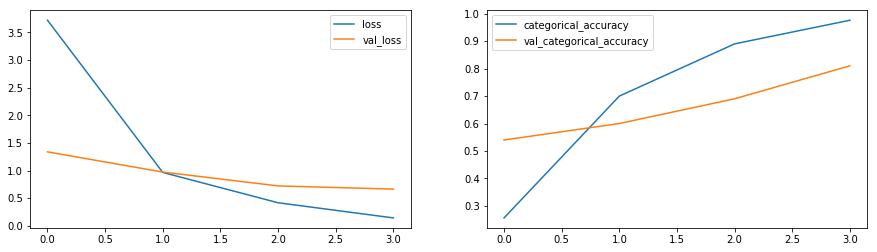

In [52]:
plot(model_1_hist)

- It can be seen that with 4 epoch loss is started to decrease and accuracy is increasing

### Model 2

- Increasing the epoch from 4 to 15  
- Add more layer to extract more feature

In [61]:
# Model configuration
rows = 120
cols = 160
batch_size = 20
num_epochs = 15
learning_rate = 0.0001
classes = 5
input_shape = (frames,rows,cols,3)

# Create the model
model_2 = Sequential()
model_2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu', kernel_initializer='he_uniform'))
model_2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_2.add(Dense(classes, activation='softmax'))

# Optimizer and compiler
optimiser = Adam(lr=learning_rate)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_51 (Conv3D)           (None, 13, 118, 158, 32)  2624      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 6, 59, 79, 32)     0         
_________________________________________________________________
conv3d_52 (Conv3D)           (None, 4, 57, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 2, 28, 38, 64)     0         
_________________________________________________________________
conv3d_53 (Conv3D)           (None, 1, 27, 37, 128)    65664     
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 1, 13, 18, 128)    0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 29952)             0         
__________

In [62]:
# fit model
model_2_hist = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


 Source path =  Project_data/val ; batch size = 20

 Source path =  Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 75s 2s/step - loss: 1.5313 - categorical_accuracy: 0.3444 - val_loss: 1.1728 - val_categorical_accuracy: 0.5900

Epoch 00001: val_loss improved from inf to 1.17282, saving model to model_init_2020-11-0904_15_19.043083/model-00001-1.54132-0.33635-1.17282-0.59000.h5
Epoch 2/15
34/34 [==============================] - 73s 2s/step - loss: 0.9241 - categorical_accuracy: 0.6939 - val_loss: 0.8975 - val_categorical_accuracy: 0.6400

Epoch 00002: val_loss improved from 1.17282 to 0.89747, saving model to model_init_2020-11-0904_15_19.043083/model-00002-0.91848-0.70287-0.89747-0.64000.h5
Epoch 3/15
34/34 [==============================] - 68s 2s/step - loss: 0.6037 - categorical_accuracy: 0.8028 - val_loss: 0.7963 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss improved from 0.89747 to 0.79627, saving model to model_init_2020-11-

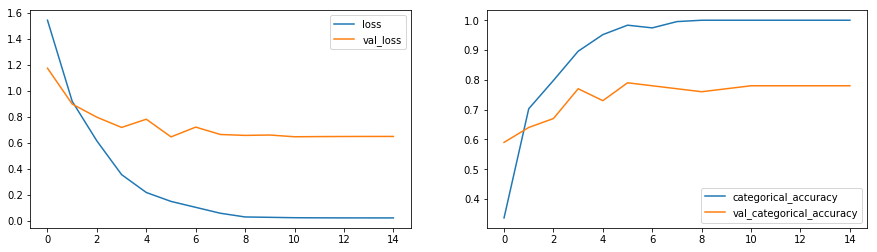

In [63]:
plot(model_2_hist)

- Model is getting overfitted after some epochs

### Model 3

- One more dense layer with dropouts and batch normalization

In [74]:
# Model configuration
rows = 120
cols = 160
batch_size = 20
num_epochs = 15
learning_rate = 0.0001
classes = 5
input_shape = (frames,rows,cols,3)

# Create the model
model_3 = Sequential()
model_3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.5))
model_3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.5))
model_3.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu', kernel_initializer='he_uniform'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_3.add(Dropout(0.25))
model_3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

model_3.add(Dense(classes, activation='softmax'))

# Optimizer and compiler
optimiser = Adam(lr=learning_rate)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_54 (Conv3D)           (None, 13, 118, 158, 32)  2624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 118, 158, 32)  128       
_________________________________________________________________
max_pooling3d_46 (MaxPooling (None, 6, 59, 79, 32)     0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 6, 59, 79, 32)     0         
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 4, 57, 77, 64)     55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 57, 77, 64)     256       
_________________________________________________________________
max_pooling3d_47 (MaxPooling (None, 2, 28, 38, 64)     0         
__________

In [75]:
# fit model
model_3_hist = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


 Source path =  Project_data/val ; batch size = 20

 Source path =  Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 79s 2s/step - loss: 2.1897 - categorical_accuracy: 0.3274 - val_loss: 3.1912 - val_categorical_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 3.19120, saving model to model_init_2020-11-0904_36_04.306405/model-00001-2.19341-0.32730-3.19120-0.28000.h5
Epoch 2/15
34/34 [==============================] - 66s 2s/step - loss: 1.2695 - categorical_accuracy: 0.5129 - val_loss: 3.3332 - val_categorical_accuracy: 0.2900

Epoch 00002: val_loss did not improve from 3.19120
Epoch 3/15
34/34 [==============================] - 72s 2s/step - loss: 1.0300 - categorical_accuracy: 0.6115 - val_loss: 3.3717 - val_categorical_accuracy: 0.3200

Epoch 00003: val_loss did not improve from 3.19120

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/15
34/34 [==============================] - 69s 2s/step

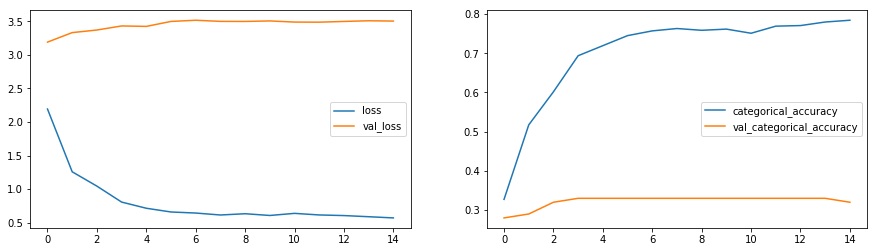

In [76]:
plot(model_3_hist)

- Model is underperforming on validation data

### Model 4

- Reducing neurons at dense layer
- Optimizing number of training parameter
- Dropouts only at dense layer

In [12]:
# Model configuration
rows = 120
cols = 160
batch_size = 20
num_epochs = 15
learning_rate = 0.0001
classes = 5
input_shape = (frames,rows,cols,3)

# Create the model
model_4 = Sequential()
model_4.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu', padding='same' ,kernel_initializer='he_uniform', input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(Dense(classes, activation='softmax'))

# Optimizer and compiler
optimiser = Adam(lr=learning_rate)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 13, 118, 158, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 118, 158, 8)   32        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 59, 79, 8)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 57, 77, 16)     3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 57, 77, 16)     64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 2, 28, 38, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 28, 38, 32)     13856     
__________

In [13]:
# fit model
model_4_hist = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


 Source path =  Project_data/val ; batch size = 20

 Source path =  Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 152s 4s/step - loss: 1.9747 - categorical_accuracy: 0.2789 - val_loss: 1.7258 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 1.72576, saving model to model_init_2020-11-0905_13_29.256661/model-00001-1.98974-0.27753-1.72576-0.31000.h5
Epoch 2/15
34/34 [==============================] - 84s 2s/step - loss: 1.5832 - categorical_accuracy: 0.3606 - val_loss: 1.4960 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss improved from 1.72576 to 1.49601, saving model to model_init_2020-11-0905_13_29.256661/model-00002-1.56422-0.36953-1.49601-0.40000.h5
Epoch 3/15
34/34 [==============================] - 84s 2s/step - loss: 1.3338 - categorical_accuracy: 0.4628 - val_loss: 1.3401 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss improved from 1.49601 to 1.34010, saving model to model_init_2020-11

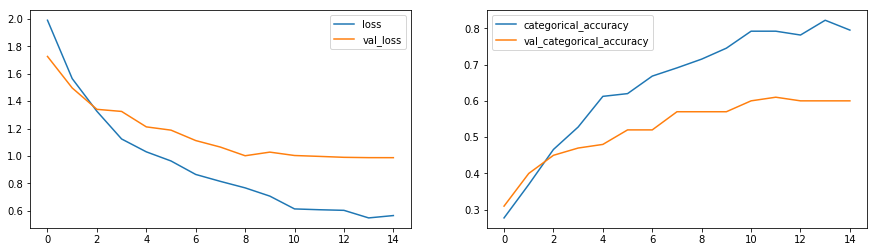

In [16]:
plot(model_4_hist)

## CNN + RNN 

### cnnrnn 1

In [43]:
# Model configuration
rows = 120
cols = 160
batch_size = 20
num_epochs = 15
learning_rate = 0.0001
classes = 5
input_shape = (frames,rows,cols,3)

# Model 
cnnrnn_1 = Sequential()

cnnrnn_1.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


cnnrnn_1.add(TimeDistributed(Conv2D(16, (3,3),padding='same', activation='relu')))
cnnrnn_1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

cnnrnn_1.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
cnnrnn_1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

cnnrnn_1.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
cnnrnn_1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

cnnrnn_1.add(TimeDistributed(BatchNormalization()))
cnnrnn_1.add(Dropout(0.25))

cnnrnn_1.add(TimeDistributed(Flatten()))

cnnrnn_1.add(Dense(128, activation='relu'))
cnnrnn_1.add(Dropout(0.25))
cnnrnn_1.add(Dense(64, activation='relu'))
cnnrnn_1.add(Dropout(0.25))

## using GRU as the RNN model along with softmax
cnnrnn_1.add(GRU(128, return_sequences=False))
cnnrnn_1.add(Dense(classes, activation='softmax')) 

# Optimizer and compiler
optimiser = Adam(lr=learning_rate)
cnnrnn_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnnrnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 15, 60, 80, 8)     224       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 60, 80, 16)    1168      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 30, 40, 32)    4640      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 15, 20, 32)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 15, 20, 64)    8256      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 7, 10, 64)     0         
__________

In [44]:
# fit model
cnnrnn_1_hist = cnnrnn_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


 Source path =  Project_data/val ; batch size = 20

 Source path =  Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - 78s 2s/step - loss: 1.4977 - categorical_accuracy: 0.3252 - val_loss: 1.3351 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.33510, saving model to model_init_2020-11-0905_39_39.642881/model-00001-1.49272-0.33333-1.33510-0.49000.h5
Epoch 2/15
34/34 [==============================] - 67s 2s/step - loss: 1.2139 - categorical_accuracy: 0.5372 - val_loss: 1.2443 - val_categorical_accuracy: 0.4600

Epoch 00002: val_loss improved from 1.33510 to 1.24425, saving model to model_init_2020-11-0905_39_39.642881/model-00002-1.22057-0.53394-1.24425-0.46000.h5
Epoch 3/15
34/34 [==============================] - 76s 2s/step - loss: 1.0601 - categorical_accuracy: 0.5990 - val_loss: 1.1802 - val_categorical_accuracy: 0.5300

Epoch 00003: val_loss improved from 1.24425 to 1.18016, saving model to model_init_2020-11-

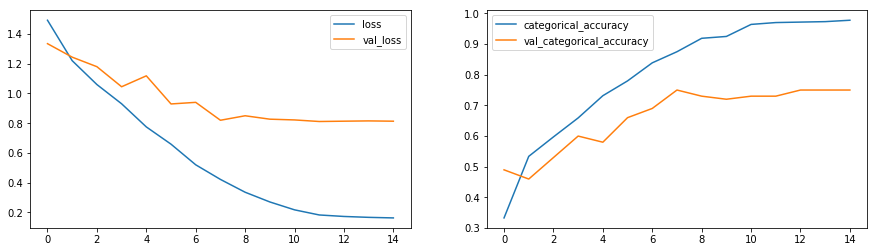

In [45]:
plot(cnnrnn_1_hist)

### cnnrnn 2

- Battling overfitiing
- Applying regularization
- More dropouts

In [57]:
# Model configuration
rows = 120
cols = 160
batch_size = 20
num_epochs = 15
learning_rate = 0.0001
classes = 5
input_shape = (frames,rows,cols,3)

# Model 
cnnrnn_2 = Sequential()

cnnrnn_2.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
cnnrnn_2.add(TimeDistributed(BatchNormalization()))

cnnrnn_2.add(TimeDistributed(Conv2D(16, (3,3),padding='same', activation='relu')))
cnnrnn_2.add(TimeDistributed(BatchNormalization()))
cnnrnn_2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
cnnrnn_2.add(Dropout(0.25))

cnnrnn_2.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
cnnrnn_2.add(TimeDistributed(BatchNormalization()))
cnnrnn_2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

cnnrnn_2.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
cnnrnn_2.add(TimeDistributed(BatchNormalization()))
cnnrnn_2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
cnnrnn_2.add(Dropout(0.25))

cnnrnn_2.add(TimeDistributed(Flatten()))

cnnrnn_2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnnrnn_2.add(Dropout(0.25))
cnnrnn_2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnnrnn_2.add(Dropout(0.25))

## using GRU as the RNN model along with softmax
cnnrnn_2.add(GRU(128, return_sequences=False))
cnnrnn_2.add(Dense(classes, activation='softmax')) 

# Optimizer and compiler
optimiser = Adam(lr=learning_rate)
cnnrnn_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnnrnn_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 15, 60, 80, 8)     224       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 15, 60, 80, 8)     32        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 15, 60, 80, 16)    1168      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 60, 80, 16)    64        
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 30, 40, 16)    0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 15, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 30, 40, 32)    4640      
__________

In [58]:
# fit model
cnnrnn_2_hist = cnnrnn_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


 Source path =  Project_data/val ; batch size = 20

 Source path =  Epoch 1/15Project_data/train ; batch size = 20

34/34 [==============================] - 77s 2s/step - loss: 1.8612 - categorical_accuracy: 0.3098 - val_loss: 1.7033 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.70334, saving model to model_init_2020-11-0906_05_27.734180/model-00001-1.86007-0.30920-1.70334-0.36000.h5
Epoch 2/15
34/34 [==============================] - 62s 2s/step - loss: 1.5893 - categorical_accuracy: 0.5099 - val_loss: 1.5357 - val_categorical_accuracy: 0.4800

Epoch 00002: val_loss improved from 1.70334 to 1.53569, saving model to model_init_2020-11-0906_05_27.734180/model-00002-1.59073-0.51433-1.53569-0.48000.h5
Epoch 3/15
34/34 [==============================] - 74s 2s/step - loss: 1.3970 - categorical_accuracy: 0.5953 - val_loss: 1.4996 - val_categorical_accuracy: 0.4800

Epoch 00003: val_loss improved from 1.53569 to 1.49965, saving model to model_init_2020-11-

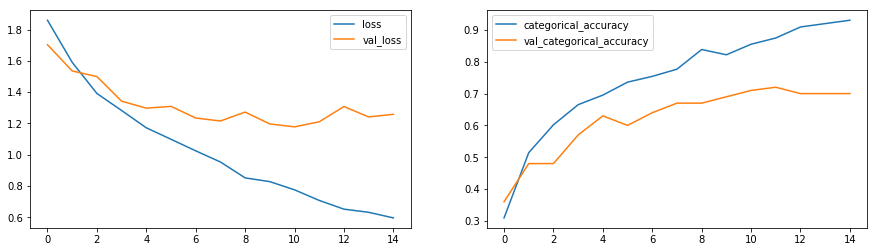

In [59]:
plot(cnnrnn_2_hist)

- After few epochs model is overfitting so best parameters are choosen at 11 th epoch which is best generalized with total parameters 671,349 so far in cnnrnn models.